# **Set Working Directory**

In [1]:
%cd 'drive/My Drive/LOCALIZATION/Transfer-Learning-Localization'
%ls

/content/drive/My Drive/LOCALIZATION/Transfer-Learning-Localization
CIMATDATASETS/  models/   __pycache__/  utils.py
main.ipynb      outputs/  README.md


# **Load required data**

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from models import models
import utils


path_dataset = 'CIMATDATASETS/CIMAT-NAO-A'
visual_map_path = path_dataset + '/Dataset-VisualMemory'
test_path = path_dataset + '/Dataset-Tests'
gt_path = path_dataset + '/gt_test_idx.csv'
train_idxs_path = path_dataset + '/train_idx.csv'
aug_path = path_dataset + '/AUG'
map_augmentation = False

# create model
classes = 187 # 187-CIMAT-NAO A, 95-CIMAT-NAO-B
model, dim = models.pretrainedmodel(classes, 'ResNet50')
model._name = 'ResNet50'
#model.summary()

# generate a single time the augmented images --OK
if map_augmentation:
    utils.mapaugmentation(visual_map_path, aug_path, 30)

# load augmented-training set
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        )

batch_size = 10
train_generator = train_datagen.flow_from_directory(
    directory=aug_path,
    target_size=  (dim[0], dim[1]),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

# load test & ground-truth data 
test_imgs, y_test, gt_test_idx, train_idx = utils.loadtestimages(test_path, dim, gt_path, train_idxs_path)


Found 5595 images belonging to 187 classes.


258it [00:01, 175.77it/s]


# **Train the model**

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf

# load visual map as validation data
val_imgs, y_val = utils.loadvisualmap(visual_map_path, dim)

# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.05, patience=50, verbose=1, restore_best_weights = True)
checkpoint_filepath = 'outputs/A_ResNet_l2.hdf5' 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
		filepath=checkpoint_filepath,
		monitor='val_loss',
		save_best_only=True, 
		#save_weights_only=True,
		verbose=1)
callbacks = [model_checkpoint_callback, early_stopping]

# compile model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])

# train model
BS = 128
EPOCHS = 2

print("[INFO] training network for {} epochs...".format(EPOCHS))
H = model.fit(
	train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data = (val_imgs, y_val),
    batch_size = BS, 
	epochs=EPOCHS,
    callbacks = callbacks)

187it [00:01, 172.46it/s]


[INFO] training network for 2 epochs...
Epoch 1/2
559/559 [==============================] - ETA: 0s - loss: 5.2372 - accuracy: 0.0045 - top_k_categorical_accuracy: 0.0111
Epoch 00001: val_loss improved from inf to 5.22997, saving model to outputs/A_ResNet_l2.hdf5
559/559 [==============================] - 42s 75ms/step - loss: 5.2372 - accuracy: 0.0045 - top_k_categorical_accuracy: 0.0111 - val_loss: 5.2300 - val_accuracy: 0.0053 - val_top_k_categorical_accuracy: 0.0267
Epoch 2/2
559/559 [==============================] - ETA: 0s - loss: 5.2315 - accuracy: 0.0054 - top_k_categorical_accuracy: 0.0154
Epoch 00002: val_loss improved from 5.22997 to 5.22839, saving model to outputs/A_ResNet_l2.hdf5
559/559 [==============================] - 42s 74ms/step - loss: 5.2315 - accuracy: 0.0054 - top_k_categorical_accuracy: 0.0154 - val_loss: 5.2284 - val_accuracy: 0.0160 - val_top_k_categorical_accuracy: 0.0428


# **Test the model**

In [16]:
model.layers[-2].name, model.layers[-2].get_weights()

('l2_layer', [array([0.8532629], dtype=float32)])

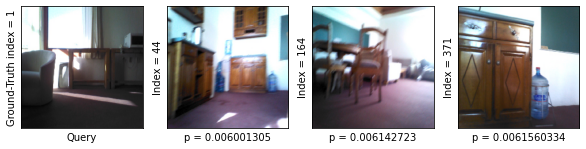

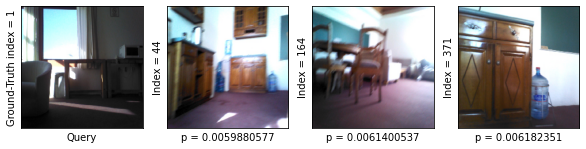

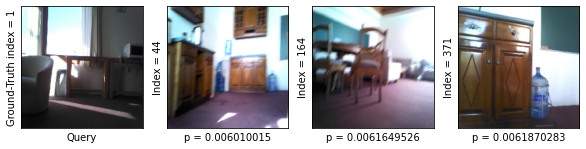

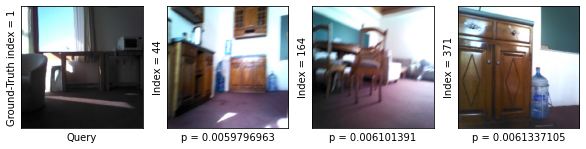

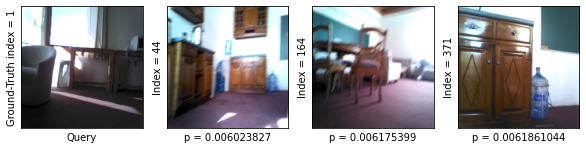

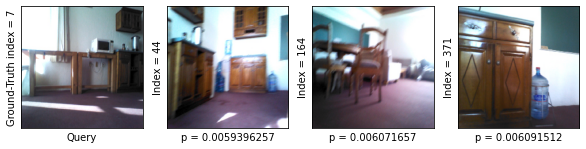

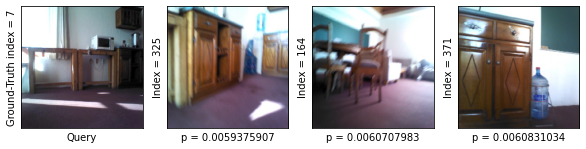

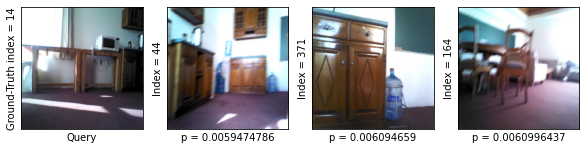

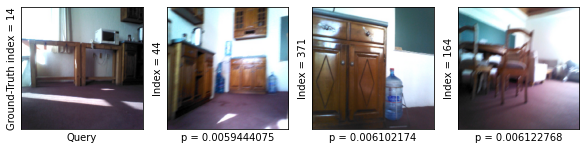

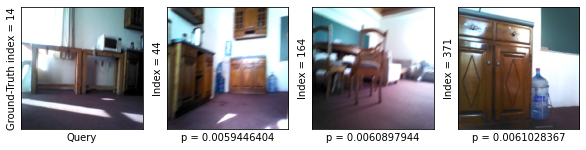

In [15]:
for i, test_img in enumerate(test_imgs[:10]):
    test_img_tensor = np.expand_dims(test_img, 0)
    r = utils.localization(model, test_img_tensor, train_idx)
    utils.plottopk(val_imgs, test_img, r, gt_test_idx[i])